# Swing-up of a pendulum using Reinforcement Learning approach


## Setup

### Imports

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tempfile
import pyvirtualdisplay

import tensorflow as tf
import pendulum_environment


from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.replay_buffers.py_uniform_replay_buffer import PyUniformReplayBuffer
from tf_agents.specs import tensor_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import epsilon_greedy_policy
from pendulum_environment.utils import TFPrioritizedReplayBuffer
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

tempdir = tempfile.gettempdir()


### Help Functions

In [3]:
# Function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# Function to create an varying epsilon for the epsilon greedy policy
def update_epsilon(step, initial_epsilon, final_epsilon, decay_steps):
    return max(final_epsilon, initial_epsilon - (initial_epsilon - final_epsilon) * (step / decay_steps))

# function to compute the average return of the reward function of the last 
# 'num_episodes' episodes
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# function to collect step in the environment and add trajectory to replay buffer
def collect_step(replay_buffer,environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  replay_buffer.add_batch(traj)

# Function to create a mp4 file in the notebook
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# function to create a mp4 file from the simulation of the environment
def create_policy_eval_video(tf_environment, py_environment, policy, filename, num_episodes=5, fps=100):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = tf_environment.reset()
      video.append_data(py_environment.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = tf_environment.step(action_step.action)
        video.append_data(py_environment.render())
  return embed_mp4(filename)

### Hyperparameters

In [4]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}


batch_size = 256  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}
n_step_update = 1

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 200 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}


### Environment

In [5]:
env_name = 'pendulum_environment/Pendulum-v0'
env_eval_name = 'pendulum_environment_evaluation/Pendulum_eval-v0'
env = suite_gym.load(env_name)



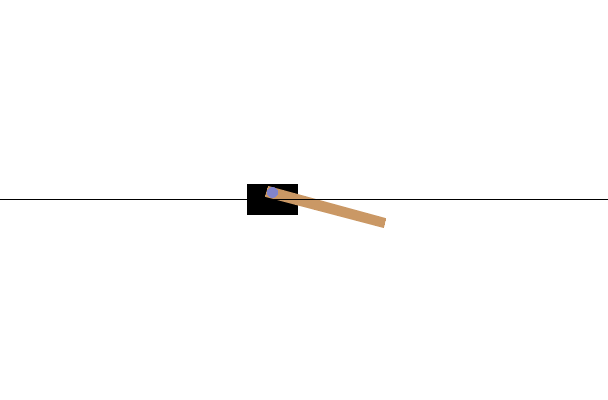

In [6]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-5.0000000e-01 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38], maximum=[5.0000000e-01 3.4028235e+38 3.4028235e+38 3.4028235e+38])


In [8]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [9]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-5.0, maximum=5.0)


In [10]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array([0.0], dtype=np.float32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.25627914, -1.9971049 , -0.4827664 ,  3.3334546 ], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1),
 'reward': array(-0.18510142, dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.2609145 , -1.9613934 , -0.44500563,  3.8075492 ], dtype=float32)})


Usually two environments are instantiated: one for training and one for evaluation.

In [11]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_eval_name)

In [12]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

### configuration of the agent's neural network layers

In [13]:
#fc_layer_params = (128,256, 512, 128)
##fc_layer_params = (1024, 512, 256)
##fc_layer_params = (1024,512, 128)
#
#
#action_tensor_spec = tensor_spec.from_spec(env.action_spec())
#num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
#
#
#
## QNetwork consists of a sequence of Dense layers followed by a dense layer
## with `num_actions` units to generate one q_value per available action as
## its output.
#dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
#q_values_layer = tf.keras.layers.Dense(
#    num_actions,
#    activation=None,
#    kernel_initializer=tf.keras.initializers.RandomUniform(
#        minval=-0.03, maxval=0.03),
#    bias_initializer=tf.keras.initializers.Constant(-0.2))
#q_net = sequential.Sequential(dense_layers + [q_values_layer])

### Initialization of the Agent

In [14]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#
#train_step_counter = tf.Variable(0)
#
#agent = dqn_agent.DdqnAgent(
#    train_env.time_step_spec(),
#    train_env.action_spec(),
#    q_network=q_net,
#    optimizer=optimizer,
#    td_errors_loss_fn=common.element_wise_squared_loss,
#    train_step_counter=train_step_counter,
#    gamma=0.995,
#    )
#
#agent.initialize()

In [15]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(train_env))


critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params,
    kernel_initializer='glorot_uniform',
    last_kernel_initializer='glorot_uniform')

actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))


train_step = train_utils.create_train_step()

agent = sac_agent.SacAgent(
    time_step_spec,
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.keras.optimizers.Adam(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.keras.optimizers.Adam(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.keras.optimizers.Adam(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    train_step_counter=train_step)

agent.initialize()


### Initialization of the epsilon greedy policy

In [16]:
initial_epsilon = 1
final_epsilon = 0.01
epsilon_decay_steps = 10000

epsilon_greedy_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
    policy=agent.policy,
    epsilon=initial_epsilon
)


## Policies



In [17]:
#eval_policy = agent.policy
#collect_policy = agent.collect_policy

In [35]:
tf_eval_policy = agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)


In [36]:
tf_collect_policy = agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)


In [37]:
random_policy = random_py_policy.RandomPyPolicy(
  train_py_env.time_step_spec(), train_py_env.action_spec())


In [18]:
#random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
#                                                train_env.action_spec())

## Metrics and Evaluation


### Computation of the average return for a random policy
This calculation gives the baseline for the performance of the agent

In [19]:
compute_avg_return(train_env, random_policy, num_eval_episodes)

-353.02338

## Replay Buffer



In [20]:
#replay_buffer = TFPrioritizedReplayBuffer(
#    data_spec=agent.collect_data_spec,
#    batch_size=train_env.batch_size,
#    max_length=replay_buffer_max_length)
#
#for _ in range(initial_collect_steps):
#  collect_step(replay_buffer, train_env, random_policy)
#
## This loop is so common in RL, that we provide standard implementations of
## these. For more details see the drivers module.
#
## Dataset generates trajectories with shape [BxTx...] where
## T = n_step_update + 1.
#dataset = replay_buffer.as_dataset(
#    num_parallel_calls=3, sample_batch_size=batch_size,
#    num_steps=n_step_update + 1).prefetch(3)
#dataset
#
#iterator = iter(dataset)

In [42]:
replay_buffer = TFPrioritizedReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

replay_observer = replay_buffer.add_batch

py_driver.PyDriver(
    train_py_env,
    random_policy,
    [replay_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

# Create a dataset from the replay buffer
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

experience_dataset_fn = lambda: dataset

iterator = iter(dataset)

InvalidArgumentError: {{function_node __wrapped__ResourceScatterUpdate_device_/job:localhost/replica:0/task:0/device:CPU:0}} Must have updates.shape = indices.shape + params.shape[1:] or updates.shape = [], got updates.shape [4], indices.shape [1], params.shape [100000,4] [Op:ResourceScatterUpdate] name: 

In [39]:
initial_collect_actor = actor.Actor(
  train_py_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[replay_observer])
initial_time_step = train_py_env.reset()

try:
    initial_collect_actor.run()
except AttributeError as e:
    print("Caught AttributeError:", e)
    print("Initial TimeStep:", initial_time_step)
    print("Observation Spec:", train_py_env.observation_spec())
    print("Action Spec:", train_py_env.action_spec())
    print("Policy TimeStep Spec:", random_policy.time_step_spec)
    print("Policy Action Spec:", random_policy.action_spec)
    raise


InvalidArgumentError: {{function_node __wrapped__ResourceScatterUpdate_device_/job:localhost/replica:0/task:0/device:CPU:0}} Must have updates.shape = indices.shape + params.shape[1:] or updates.shape = [], got updates.shape [4], indices.shape [1], params.shape [100000,4] [Op:ResourceScatterUpdate] name: 

In [24]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  train_py_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[replay_observer, env_step_metric])


In [26]:
eval_actor = actor.Actor(
  train_py_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)


In [30]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  agent,
  experience_dataset_fn,
  triggers=learning_triggers,
  )


TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [28]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)


c:\Users\sameb\Git\pendulum_environment\.venv\Lib\site-packages\gym\spaces\box.py:155: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


KeyboardInterrupt: 

## Data Collection

## Training the agent with the environment with all possible initial states

In [ ]:
#try:
#  %%time
#except:
#  pass
#
## (Optional) Optimize by wrapping some of the code in a graph using TF function.
#agent.train = common.function(agent.train)
#
## Reset the train step
#agent.train_step_counter.assign(0)
#
## Evaluate the agent's policy once before training.
#avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
#returns = [avg_return]
#
#for step in range(num_iterations):
#
#  current_epsilon = update_epsilon(step, initial_epsilon, final_epsilon, epsilon_decay_steps)
#  epsilon_greedy_policy._epsilon = current_epsilon  # Update the epsilon in the policy
#  # Collect a few steps using collect_policy and save to the replay buffer.
#  for _ in range(collect_steps_per_iteration):
#    collect_step(replay_buffer,train_env, agent.collect_policy)
#
#  # Sample a batch of data from the buffer and update the agent's network.
#  experience, unused_info = next(iterator)
#  train_loss = agent.train(experience)
#
#  step = agent.train_step_counter.numpy()
#
#  if step % log_interval == 0:
#    print('step = {0}: loss = {1}'.format(step, train_loss.loss))
#
#  if step % eval_interval == 0:
#    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
#    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
#    returns.append(avg_return)
#

In [ ]:
#try:
#  %%time
#except:
#  pass
#
## (Optional) Optimize by wrapping some of the code in a graph using TF function.
#agent.train = common.function(agent.train)
#
## Reset the train step.
#agent.train_step_counter.assign(0)
#
## Evaluate the agent's policy once before training.
#avg_return = compute_avg_return(train_env, agent.policy, num_eval_episodes)
#returns = [avg_return]
#
## Reset the environment.
#time_step = train_env.reset()
#
## Create a driver to collect experience.
#collect_driver = dynamic_step_driver.DynamicStepDriver(
#    train_env,
#    agent.collect_policy,
#    observers=replay_observer,
#    num_steps=collect_steps_per_iteration)
#
#for step in range(num_iterations):
#  current_epsilon = update_epsilon(step, initial_epsilon, final_epsilon, epsilon_decay_steps)
#  epsilon_greedy_policy._epsilon = current_epsilon  # Update the epsilon in the policy
#  # Collect a few steps and save to the replay buffer.
#  time_step, _ = collect_driver.run(time_step)
#
#  # Sample a batch of data from the buffer and update the agent's network.
#  experience, unused_info = next(iterator)
#  train_loss = agent.train(experience).loss
#
#  step = agent.train_step_counter.numpy()
#
#  if step % log_interval == 0:
#    print('step = {0}: loss = {1}'.format(step, train_loss))
#
#  if step % eval_interval == 0:
#    avg_return = compute_avg_return(train_env, agent.policy, num_eval_episodes)
#    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
#    returns.append(avg_return)



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 1088935296.0
step = 400: loss = 122103513088.0
step = 600: loss = 1172254208.0
step = 800: loss = 10625986.0
step = 1000: loss = 7291680.0
step = 1000: Average Return = -328.1512451171875
step = 1200: loss = 1316027.25
step = 1400: loss = 969304.0625
step = 1600: loss = 620266.5
step = 1800: loss = 10822615.0
step = 2000: loss = 210505.625
step = 2000: Average Return = -337.0355224609375
step = 2200: loss = 383164.125
step = 2400: loss = 219081.59375
step = 2600: loss = 102376.140625
step = 2800: loss = 927097.875
step = 3000: loss = 267486.40625
step = 3000: Average Return = -332.11090087890625
step = 3200: loss = 978610.0
step = 3400: loss = 1970265.25
step = 3600: loss = 160722.1875
step = 3800: loss = 81610.078125
step = 4000: loss =

In [ ]:
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

replay_observer.close()


## Visualization


### Plots of the average return

Text(0.5, 0, 'Iterations')

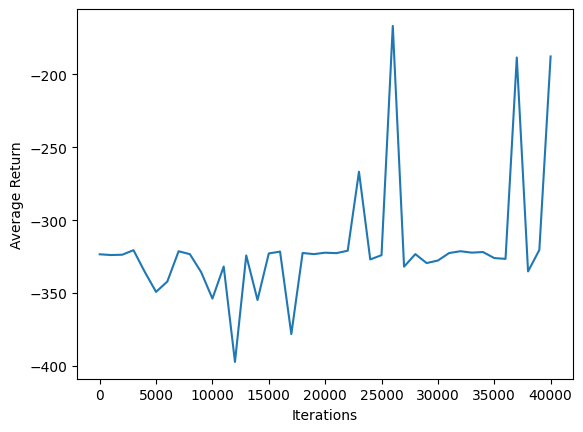

In [ ]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

### Videos

#### Environment with all possible initial states

In [ ]:
create_policy_eval_video(train_env, train_py_env, agent.policy, "trained-agent-training-environment")


#### Environment with initial states $ \boldsymbol{x} \, = \, \begin{bmatrix} 0 & 0 & 0 & 0 \end{bmatrix}^T $

In [ ]:
create_policy_eval_video(eval_env, eval_py_env, agent.policy, "trained-agent")


#### Save the model

In [ ]:
#global_step = tf.compat.v1.train.get_global_step()
#cwd = os.getcwd()
#name = '50000_(128,256, 512, 128)'
#new_checkpoint = os.path.join(cwd, 'checkpoints',name)
#train_checkpointer = common.Checkpointer(
#    ckpt_dir=new_checkpoint,
#    max_to_keep=1,
#    agent=agent,
#    policy=agent.policy,
#    replay_buffer=replay_buffer,
#)
#train_checkpointer.save(global_step)
#

## Second Training

### configuration of the new epsilon greedy policy

In [ ]:
#initial_epsilon = 0.5
#final_epsilon = 0.01
#epsilon_decay_steps = 10000
#
#epsilon_greedy_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
#    policy=agent.policy,
#    epsilon=initial_epsilon
#)

AttributeError: 'EpsilonGreedyPolicy' object has no attribute 'EpsilonGreedyPolicy'